# Contents

[1. Loading data](#1.-Loading-data)  

[2. Exploratory data analysis  ](#2.-Exploratory-data-analysis)  

[3. Preprocessing](#3.-Preprocessing)  

[placeholder](#placeholder)  

[placeholder](#placeholder) 

[placeholder](#placeholder)  


***

# 1. Loading data

This data set includes customers who have paid off their loans, who have been past due and put into collection without paying back their loan and interests, and who have paid off only after they were put in collection. The financial product is a bullet loan that customers should pay off all of their loan debt in just one time by the end of the term, instead of an installment schedule. Of course, they could pay off earlier than their pay schedule.

The training dataset includes details of 500 customers whose loan are already paid off or defaulted. It includes following main variables:

| Variable          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_id        | A unique loan number assigned to each loan customers
| Loan_status    | Whether a loan is paid off, in collection, new customer yet to payoff, or paid off after the collection efforts                                           |
| Principal      | Basic principal loan amount at the origination                                                    |
| terms          | Can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Paidoff_time   | The actual time a customer pays off the loan
| Pastdue_days   | How many days a loan has been past due
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

In [25]:
import pandas as pd
from importlib import reload
import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn import preprocessing

# load tools
import functions as f
import classification as c

In [7]:
df0 = pd.read_csv("data.csv")
print(f"Number of observations: ", df0.shape[0])
print(f"Number of variables, including the response: ", df0.shape[1])
df0.head()


Number of observations:  500
Number of variables, including the response:  11


,Loan_ID,loan_status,Principal,terms,effective_date,due_date,paid_off_time,past_due_days,age,education,Gender
0,xqd20166231,PAIDOFF,1000,30,9/8/2016,10/7/2016,9/14/2016 19:31,NaN,45,High School or Below,male
1,xqd20168902,PAIDOFF,1000,30,9/8/2016,10/7/2016,10/7/2016 9:00,NaN,50,Bechalor,female
2,xqd20160003,PAIDOFF,1000,30,9/8/2016,10/7/2016,9/25/2016 16:58,NaN,33,Bechalor,female
3,xqd20160004,PAIDOFF,1000,15,9/8/2016,9/22/2016,9/22/2016 20:00,NaN,27,college,male
4,xqd20160005,PAIDOFF,1000,30,9/9/2016,10/8/2016,9/23/2016 21:36,NaN,28,college,female


***

# 2. Exploratory data analysis  

As a part of exploratory data analysis, we can look at statistical description of the dataset.

Quick analysis of the data shows the following:
- There are 8 categorical and 3 numerical variables.
- 7% of cells are missing values.
- There are no duplicate rows.
- `Loan_ID` is unique for each observation and doesn't add necessary information to analysis.
- The response (`loan_status`) is categorical and has 3 values:  PAIDOFF - customer paid before the due date, COLLECTION - the due date is over, but the loan is still not paid off, COLLECTION_PAIDOFF the loan was paid off after the collection date. There are more paidoff loans than unpaid ones or paid after collection.
- There are only 6 distinct values for `Principal`, however, it is recognised as numerical variable.
- There are 3 values for `terms`; only 21 observations are present in the weekly payoff schedule category, which is much less than in other categories.
- `effective_date`, `due_date`, `paid_off_time` are recognised as categorical variables instead of dates.
- There are 300 missing values in `past_due_days`, because this variable is connected with unpaid loans only.
- Age ranges from 18 to 51 years, the average age is 31, the distribution looks normal.
- `Education` has 4 categories: High School or below, college, bachelor and master; bachelor and master have the least observations.
- There are much more males than females in the dataset.

Overall, the dataset is unbalanced as the number of observations for different categories varies. This may make estimation of the effect of the class with less observations difficult. The mising values also are problematic.

In [8]:
f.get_overview(df0)

We can take a closer look at the data.

In [9]:
f.get_summary(df0,
                y=df0.loan_status,
                nan=True,
                formats=True,
                categorical=True)

NaNs:  ['paid_off_time', 'past_due_days']
Unique formats:  [dtype('O'), dtype('int64'), dtype('float64')]
Possible categorical variables (<10 unique values):  ['loan_status', 'Principal', 'terms', 'effective_date', 'education', 'Gender']


1. The missing values are in variables `paid_off_time`, `past_due_days`: 
    - NaNs appear in `paid_off_time` because the loan is still not paid off, so the date is unknown.
    - NaNs appear in `past_due_days` because the loan was paid off in time.
    So, the `past_due_days` column has no missing values only when the loan is paid off after collection, or `loan status` is COLLECTION_PAIDOFF.   
<br>
2. We need to correct formats of the categorical variables.  
<br>
3. There are several numerical variables which may be considered as categorical. In particular, terms, effective_date, education, Gender can be changed into categorical values and encoded using one hot encoding.  

***
# 3. Preprocessing  

Based on the above, there are several things we could do:



In [5]:
df = df0.copy()

def preprocess(df):
    #correct dates
    df['due_date'] = pd.to_datetime(df['due_date'])
    df['effective_date'] = pd.to_datetime(df['effective_date'])
    df.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'], inplace = True)

    #transform gender and loan_status
    df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
    df['loan_status'].replace(to_replace=['PAIDOFF','COLLECTION'], value=[0,1],inplace=True)

    #Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame
    # do not include first column on the dummies to avoid over-parameterisation
    df = pd.concat([df, pd.get_dummies(df['education']).iloc[:, 1:]], axis=1)
    #drop education because we have dummies for it as separate columns
    df.drop(['education'], axis = 1, inplace=True)

    #binning days of the week based on effective date: 1 - moday, ... , 7 - sunday
    df['dayofweek'] = df['effective_date'].dt.dayofweek+1
    
    #Labels and features
    X_features = ['Principal','terms','age','Gender','High School or Below','Master or Above','college','dayofweek']
    y_features = 'loan_status'
    X = df[X_features]
    y = df[y_features]
    
    #Data Standardization gives data zero mean and unit variance (technically should be done after train test split )
    X = preprocessing.StandardScaler().fit(X).transform(X)

    return df, X, y, X_features, y_features

df, X, y, X_features, y_features = preprocess(df)
df

,loan_status,Principal,terms,effective_date,due_date,age,Gender,High School or Below,Master or Above,college,dayofweek
0,0,1000,30,2016-09-08,2016-10-07,45,0,1,0,0,4
1,0,1000,30,2016-09-08,2016-10-07,33,1,0,0,0,4
2,0,1000,15,2016-09-08,2016-09-22,27,0,0,0,1,4
3,0,1000,30,2016-09-09,2016-10-08,28,1,0,0,1,5
4,0,1000,30,2016-09-09,2016-10-08,29,0,0,0,1,5
...,...,...,...,...,...,...,...,...,...,...,...
341,1,800,15,2016-09-11,2016-09-25,32,0,1,0,0,7
342,1,1000,30,2016-09-11,2016-10-10,25,0,1,0,0,7
343,1,800,15,2016-09-12,2016-09-26,39,0,0,0,1,1
344,1,1000,30,2016-09-12,2016-11-10,28,0,0,0,1,1


In [13]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 346 entries, 0 to 345
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      346 non-null    int64 
 1   Unnamed: 0.1    346 non-null    int64 
 2   loan_status     346 non-null    object
 3   Principal       346 non-null    int64 
 4   terms           346 non-null    int64 
 5   effective_date  346 non-null    object
 6   due_date        346 non-null    object
 7   age             346 non-null    int64 
 8   education       346 non-null    object
 9   Gender          346 non-null    object
dtypes: int64(5), object(5)
memory usage: 27.2+ KB


In [6]:
reload(f)
df_clean, df_outliers = f.IQR(df, 
          df[['Principal','terms','age','Gender','High School or Below','Master or Above','college','dayofweek']].columns, 
          q1=0.25)

Index(['Principal', 'terms', 'age', 'Gender', 'High School or Below',
       'Master or Above', 'college', 'dayofweek'],
      dtype='object')


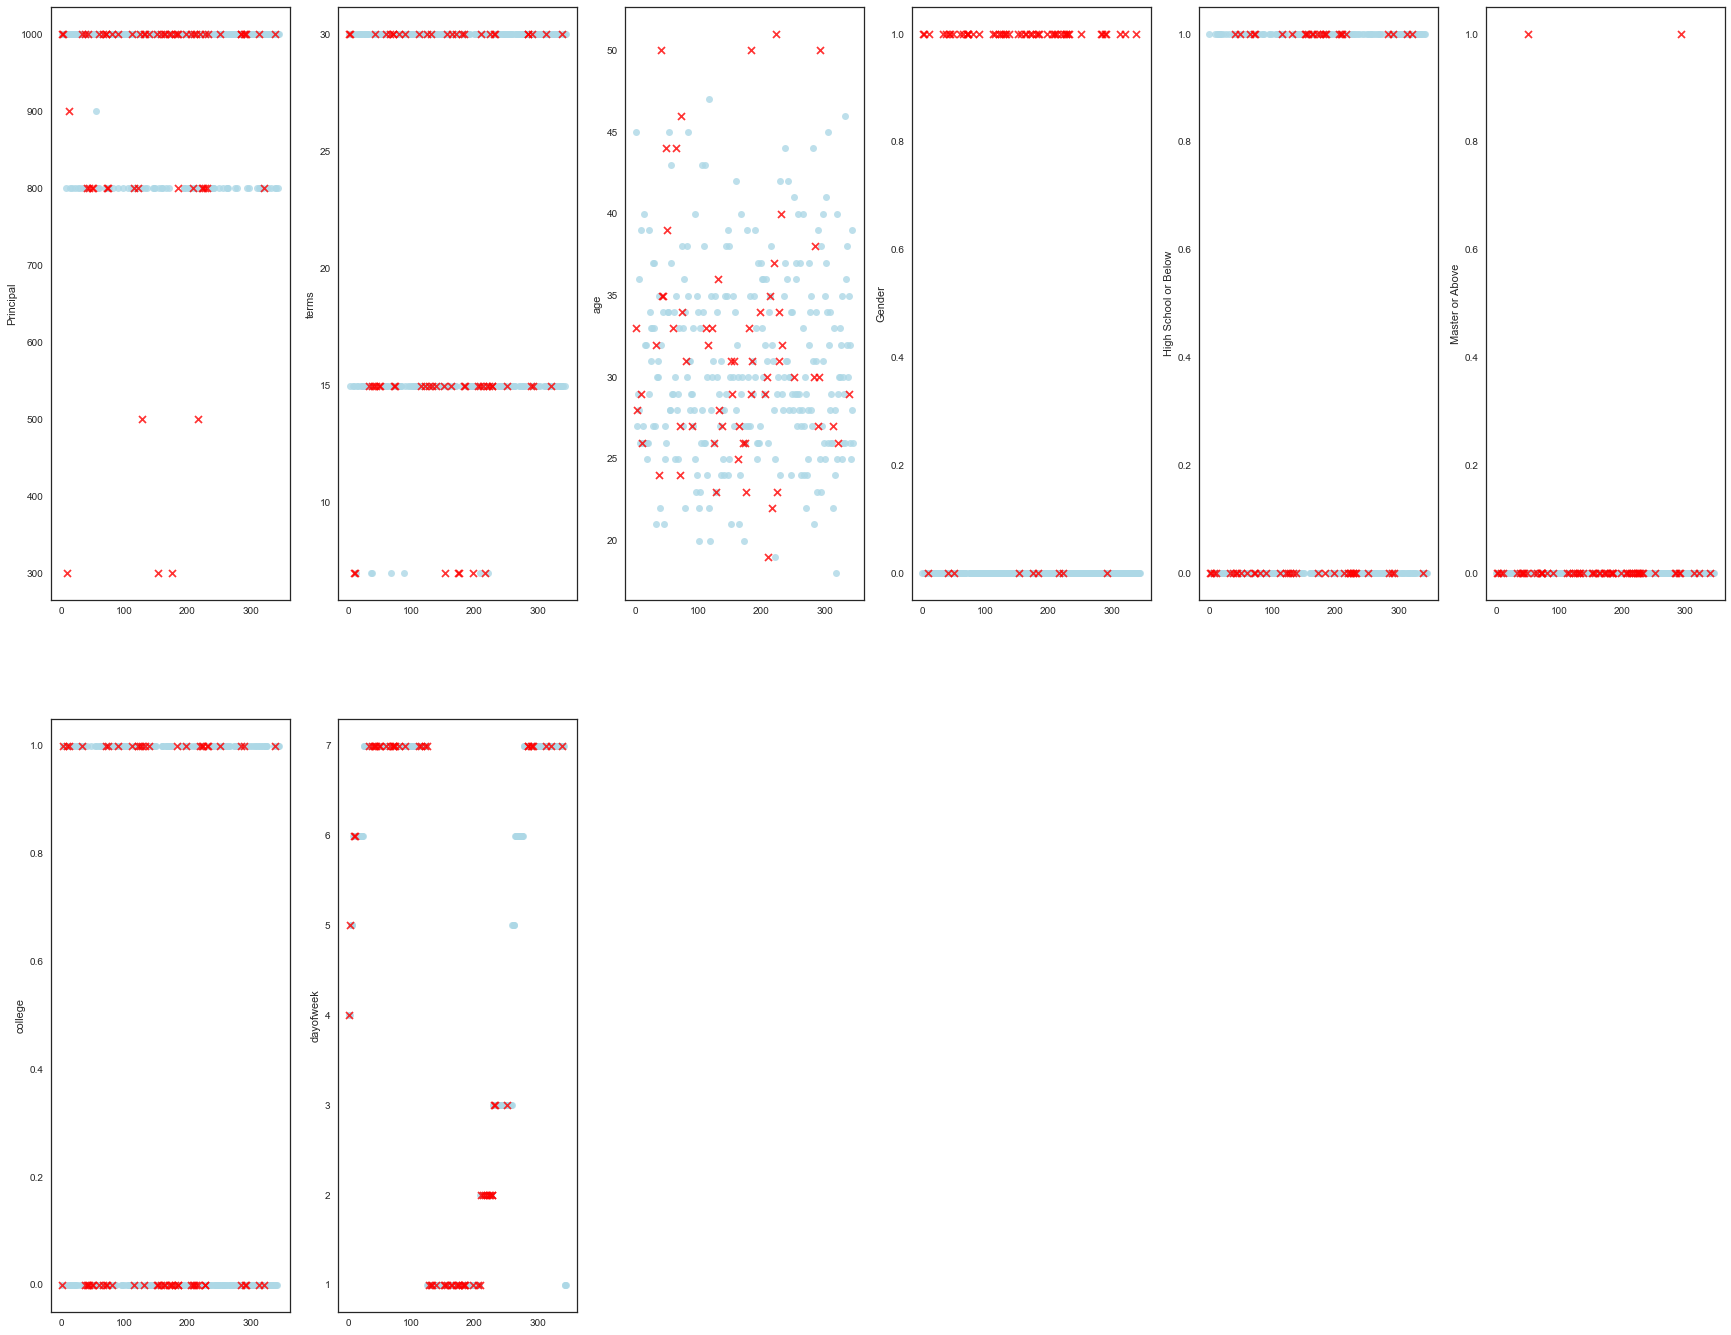

In [7]:
f.plot(df, 
       df[['Principal','terms','age','Gender','High School or Below','Master or Above','college','dayofweek']].columns, 
       df_clean, df_outliers, 
       plot_cols=6)

['Principal', 'terms', 'age', 'Gender', 'High School or Below', 'Master or Above', 'college', 'dayofweek']


(     loan_status  Principal  terms effective_date   due_date  age  Gender  \
 0              0       1000     30     2016-09-08 2016-10-07   45       0   
 2              0       1000     15     2016-09-08 2016-09-22   27       0   
 4              0       1000     30     2016-09-09 2016-10-08   29       0   
 5              0       1000     30     2016-09-09 2016-10-08   36       0   
 6              0       1000     30     2016-09-09 2016-10-08   28       0   
 ..           ...        ...    ...            ...        ...  ...     ...   
 341            1        800     15     2016-09-11 2016-09-25   32       0   
 342            1       1000     30     2016-09-11 2016-10-10   25       0   
 343            1        800     15     2016-09-12 2016-09-26   39       0   
 344            1       1000     30     2016-09-12 2016-11-10   28       0   
 345            1       1000     30     2016-09-12 2016-10-11   26       0   
 
      High School or Below  Master or Above  college  dayofwee

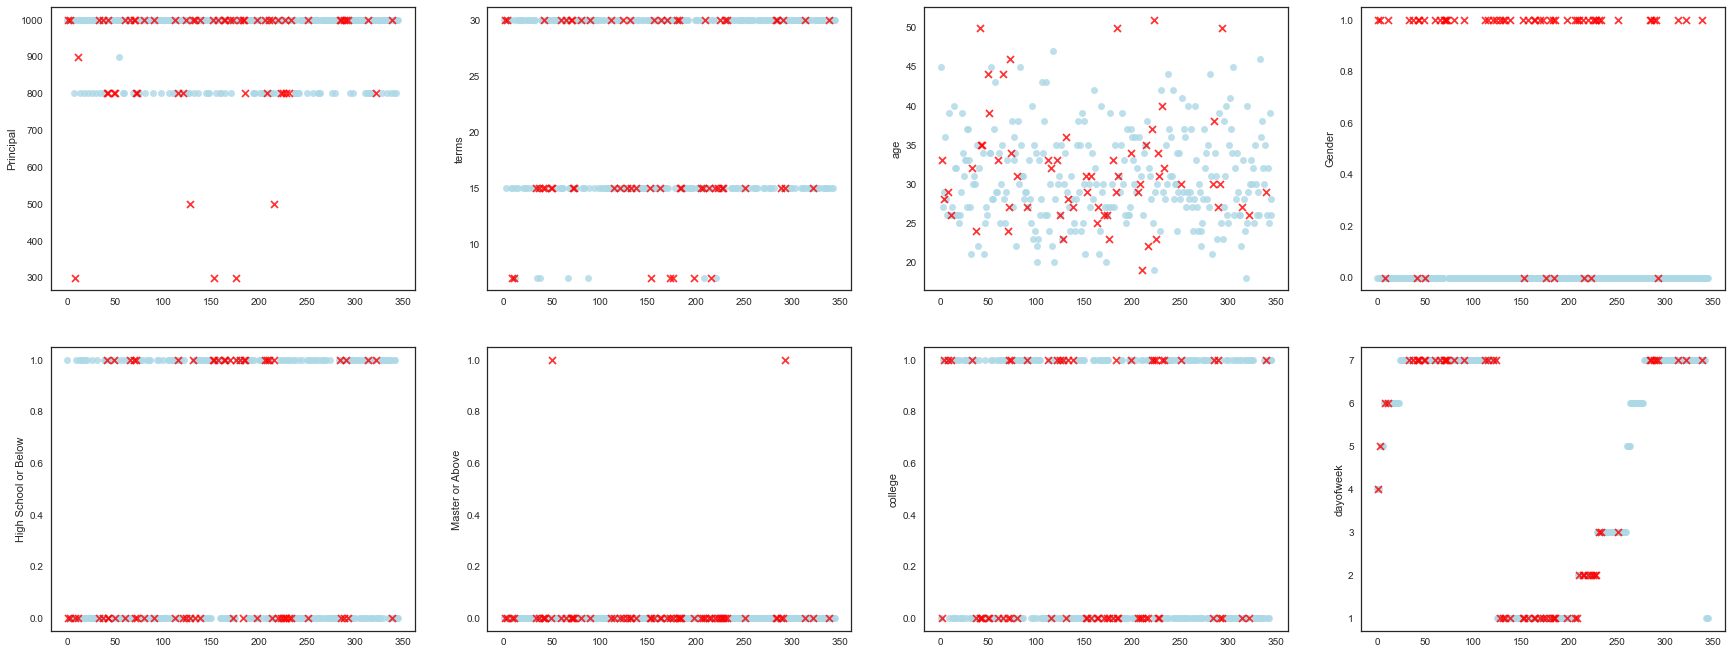

In [8]:
reload(f)
f.show(df, 
       ['Principal','terms','age','Gender','High School or Below','Master or Above','college','dayofweek'],
       how='IQR', show_plot=True, q1=0.25)

# MODELING

In [9]:
# We split the X into train and test to find the best k
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)


Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


## Classification

- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression


### K Nearest Neighbor(KNN)


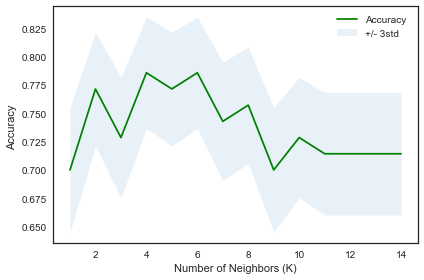

Best k out of 15 is 4 with accuracy 0.7857


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=4, p=2,
           weights='uniform')

In [10]:
reload(c)
from sklearn.neighbors import KNeighborsClassifier

#find best k out of 15
Ks=15
kNN_model = c.knn_findk(Ks, X_train, y_train, X_test, y_test)
kNN_model.fit(X_train,y_train)
# In multilabel classification, __accuracy classification score__ is a function that computes subset accuracy. 
# This function is equal to the jaccard_similarity_score function. 
# Essentially, it calculates how closely the actual labels and predicted labels are matched in the test set.
# print("Train set Accuracy: ", metrics.accuracy_score(y_train, kNN_model.predict(X_train)))
# print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat))

### Decision Tree

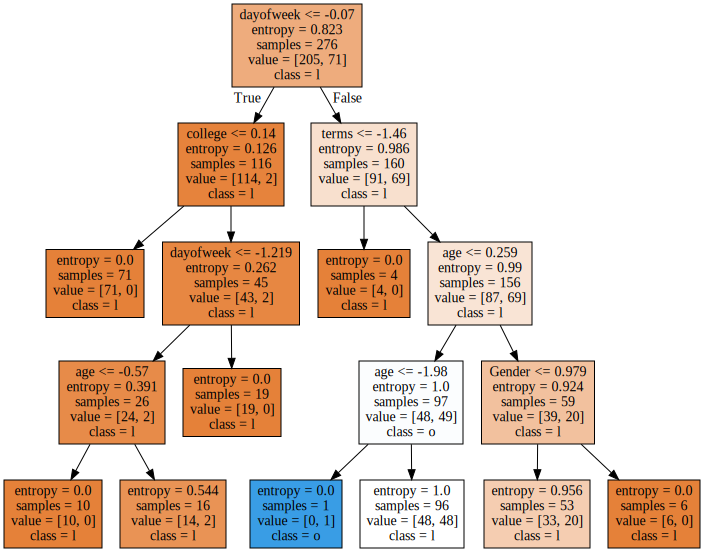

In [11]:
reload(c)
from sklearn.tree import DecisionTreeClassifier
DT_model = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
DT_model.fit(X_train,y_train)
c.plot_decisionTrees(DT_model, X_features, y_features)
# yhat = DT_model.predict(X_test)


### Support Vector Machine

Confusion matrix, without normalization


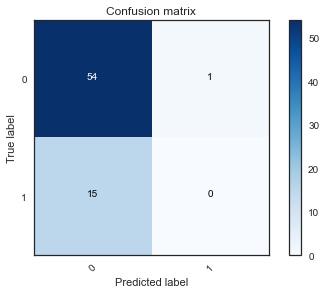

In [12]:
from sklearn import svm
SVM_model = svm.SVC()
SVM_model.fit(X_train, y_train) 

yhat = SVM_model.predict(X_test)
c.plot_confusion_matrix(y_test, yhat, labels=[0,1], normalize= False,  title='Confusion matrix')

# yhat = SVM_model.predict(X_test)


### Logistic Regression

Confusion matrix, without normalization


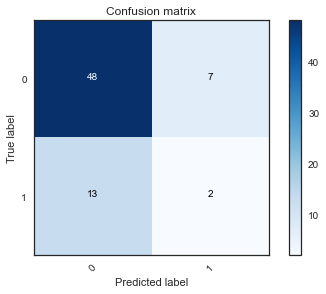

In [13]:
reload(c)
from sklearn.linear_model import LogisticRegression
LR_model = LogisticRegression(C=0.01).fit(X_train,y_train)
yhat = LR_model.predict(X_test)
# yhat_prob = LR_model.predict_proba(X_test)  #  returns estimates for all classes, ordered by the label of classes.
c.plot_confusion_matrix(y_test, yhat, labels=[0,1], normalize= False,  title='Confusion matrix')
# print (classification_report(y_test, yhat))


# Model Evaluation using Test set

In [14]:
df_test0 = pd.read_csv("https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv")
df_test0

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male
5,37,37,PAIDOFF,700,15,9/11/2016,9/25/2016,33,High School or Below,male
6,38,38,PAIDOFF,1000,15,9/11/2016,9/25/2016,24,college,male
7,48,48,PAIDOFF,1000,30,9/11/2016,10/10/2016,32,Bechalor,male
8,50,50,PAIDOFF,800,15,9/11/2016,9/25/2016,27,college,female
9,61,61,PAIDOFF,1000,15,9/11/2016,9/25/2016,37,college,male


In [15]:
reload(f)
df_test = df_test0.copy()
df_test, X_test, y_test, X_test_features, y_test_features = preprocess(df_test)

f.metrics(kNN_model, X_test, y_test)
f.metrics(DT_model, X_test, y_test)
f.metrics(SVM_model, X_test, y_test)
f.metrics(LR_model, X_test, y_test)

KNeighborsClassifier
Jaccard index: 0.67
F1-score: 0.62

DecisionTreeClassifier
Jaccard index: 0.76
F1-score: 0.67

SVC
Jaccard index: 0.76
F1-score: 0.67

LogisticRegression
Jaccard index: 0.76
F1-score: 0.67
LogLoss: 0.58

